In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix

# Constants
IMAGE_SIZE = (256, 256)
DATASET_DIR = "/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation"

2025-04-20 07:50:35.307351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745135435.511226      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745135435.582430      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_png_files(dataset_dir):
    images, masks = [], []
    
    # Load training data
    train_img_dir = os.path.join(dataset_dir, "train/Original")
    train_mask_dir = os.path.join(dataset_dir, "train/Ground truth")
    
    train_img_files = sorted(os.listdir(train_img_dir))
    
    for img_file in train_img_files:
        if img_file.endswith(".png"):
            # Load image
            img_path = os.path.join(train_img_dir, img_file)
            img = cv2.imread(img_path)
            
            # Load corresponding mask (assuming same filename in Ground truth folder)
            mask_path = os.path.join(train_mask_dir, img_file)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Resize
                img = cv2.resize(img, IMAGE_SIZE)
                mask = cv2.resize(mask, IMAGE_SIZE)
                
                # Convert to normalized grayscale if needed
                if len(img.shape) == 3 and img.shape[2] == 3:
                    # Extract green channel (most informative for retinal images)
                    img = img[:, :, 1]
                
                # Normalize and preprocess image
                img = img.astype(np.float32) / 255.0
                
                # Ensure binary mask (threshold if not already binary)
                mask = (mask > 127).astype(np.uint8)
                
                # Add channel dimension
                img = img[..., np.newaxis]
                mask = mask[..., np.newaxis]
                
                images.append(img)
                masks.append(mask)
    
    # Optionally, also load test data if needed
    test_img_dir = os.path.join(dataset_dir, "test/Original")
    test_mask_dir = os.path.join(dataset_dir, "test/Ground truth")
    
    if os.path.exists(test_img_dir) and os.path.exists(test_mask_dir):
        test_img_files = sorted(os.listdir(test_img_dir))
        
        for img_file in test_img_files:
            if img_file.endswith(".png"):
                # Load image
                img_path = os.path.join(test_img_dir, img_file)
                img = cv2.imread(img_path)
                
                # Load corresponding mask
                mask_path = os.path.join(test_mask_dir, img_file)
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    
                    # Resize
                    img = cv2.resize(img, IMAGE_SIZE)
                    mask = cv2.resize(mask, IMAGE_SIZE)
                    
                    # Convert to normalized grayscale if needed
                    if len(img.shape) == 3 and img.shape[2] == 3:
                        # Extract green channel (most informative for retinal images)
                        img = img[:, :, 1]
                    
                    # Normalize and preprocess image
                    img = img.astype(np.float32) / 255.0
                    
                    # Ensure binary mask
                    mask = (mask > 127).astype(np.uint8)
                    
                    # Add channel dimension
                    img = img[..., np.newaxis]
                    mask = mask[..., np.newaxis]
                    
                    images.append(img)
                    masks.append(mask)
    
    return np.array(images), np.array(masks)



In [3]:
# Data Augmentation function with retina-specific enhancements
def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []
    
    for img, mask in zip(images, masks):
        # Original
        augmented_images.append(img)
        augmented_masks.append(mask)
      
        # Rotation 90 degrees
        rot_img = np.rot90(img, k=1, axes=(0, 1))
        rot_mask = np.rot90(mask, k=1, axes=(0, 1))
        augmented_images.append(rot_img)
        augmented_masks.append(rot_mask)
        
        # Flipping horizontally (common for retinal images)
        flip_img = np.flip(img, axis=1)
        flip_mask = np.flip(mask, axis=1)
        augmented_images.append(flip_img)
        augmented_masks.append(flip_mask)
        
        # Brightness variation (random)
        brightness = np.random.uniform(0.8, 1.2)
        bright_img = np.clip(img * brightness, 0, 1)
        augmented_images.append(bright_img)
        augmented_masks.append(mask)
        
        # Contrast adjustment (important for retinal vessels)
        alpha = np.random.uniform(0.9, 1.1)  # Simple contrast control
        beta = np.random.uniform(-0.1, 0.1)  # Simple brightness control
        contrast_img = np.clip(alpha * img + beta, 0, 1)
        augmented_images.append(contrast_img)
        augmented_masks.append(mask)

    return np.array(augmented_images), np.array(augmented_masks)


In [4]:
# mUnet Model from the script
def mUnet_model(input_shape=(256, 256, 1)):
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = input_shape
    
    # Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = layers.Dropout(0.2)(c1)
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.2)(c2)
    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


    #Expansive path
    u6 = layers.Conv2DTranspose(600, (2, 2), strides=(2, 2), padding='same')(c5)
    m1 = layers.MaxPooling2D((8, 8))(c1)
    l1 = layers.concatenate([u6, m1])
    u6 = layers.concatenate([l1, c4])
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


    u7 = layers.Conv2DTranspose(300, (2, 2), strides=(2, 2), padding='same')(c6)
    m2 = layers.MaxPooling2D((4, 4))(c1)
    l2 = layers.concatenate([u7, m2])
    u7 = layers.concatenate([l2, c3])
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(150, (2, 2), strides=(2, 2), padding='same')(c7)
    m3 = layers.MaxPooling2D((2, 2))(c1)
    l3 = layers.concatenate([u8, m3])
    u8 = layers.concatenate([l3, c2])
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.2)(c8)
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


    u9 = layers.Conv2DTranspose(75, (2, 2), strides=(2, 2), padding='same')(c8)
    l4 = layers.concatenate([u9, c1])
    u9 = layers.concatenate([l4, c1], axis=3)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.2)(c9)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])


In [5]:
# Custom Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

# Combined loss function
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    return (intersection + smooth) / (union + smooth)


In [6]:
# Load and process data
print("Loading dataset...")
images, masks = load_png_files(DATASET_DIR)
print(f"Original dataset: {len(images)} images, {len(masks)} masks")

# Augment training data
print("Augmenting data...")
augmented_images, augmented_masks = augment_data(images, masks)
print(f"Augmented dataset: {len(augmented_images)} images, {len(augmented_masks)} masks")



Loading dataset...
Original dataset: 800 images, 800 masks
Augmenting data...
Augmented dataset: 4000 images, 4000 masks


In [7]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")



Train: 2800, Validation: 800, Test: 400


In [8]:
# Create mUnet model
model = mUnet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, iou_score]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_dice_coefficient',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_retina_vessel_segmentation_model.keras",
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)

# TensorBoard callback for visualization
tensorboard_callback = callbacks.TensorBoard(
    log_dir="./logs",
    histogram_freq=1,
    update_freq='epoch'
)

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,  # Smaller batch size due to potentially larger images
    callbacks=[early_stopping, lr_scheduler, checkpoint, tensorboard_callback]
)

# Save final model
model.save("retina_vessel_segmentation_final.keras")



I0000 00:00:1745135586.677146      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training model...
Epoch 1/100


I0000 00:00:1745135600.274960      91 service.cc:148] XLA service 0x7cb934009450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745135600.275725      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745135601.318894      91 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-20 07:53:27.222232: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[16,150,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,150,128,128]{3,2,1,0}, f32[150,150,3,3]{3,2,1,0}, f32[150]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-20

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9068 - dice_coefficient: 0.1268 - iou_score: 0.0684 - loss: 1.2316
Epoch 1: val_dice_coefficient improved from -inf to 0.25323, saving model to best_retina_vessel_segmentation_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 264s 895ms/step - accuracy: 0.9069 - dice_coefficient: 0.1271 - iou_score: 0.0687 - loss: 1.2308 - val_accuracy: 0.9275 - val_dice_coefficient: 0.2532 - val_iou_score: 0.1454 - val_loss: 1.0619 - learning_rate: 1.0000e-04
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9419 - dice_coefficient: 0.4877 - iou_score: 0.3239 - loss: 0.7038
Epoch 2: val_dice_coefficient improved from 0.25323 to 0.51672, saving model to best_retina_vessel_segmentation_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 136s 780ms/step - accuracy: 0.9419 - dice_coefficient: 0.4879 - iou_score: 0.3241 - loss: 0.7035 - val_accuracy: 0.9471 - val_dice_coefficient: 0.5167 - val_iou_score: 0.3492 - val_loss: 0.7588 - learning_rate: 1.00

Plotting training history...


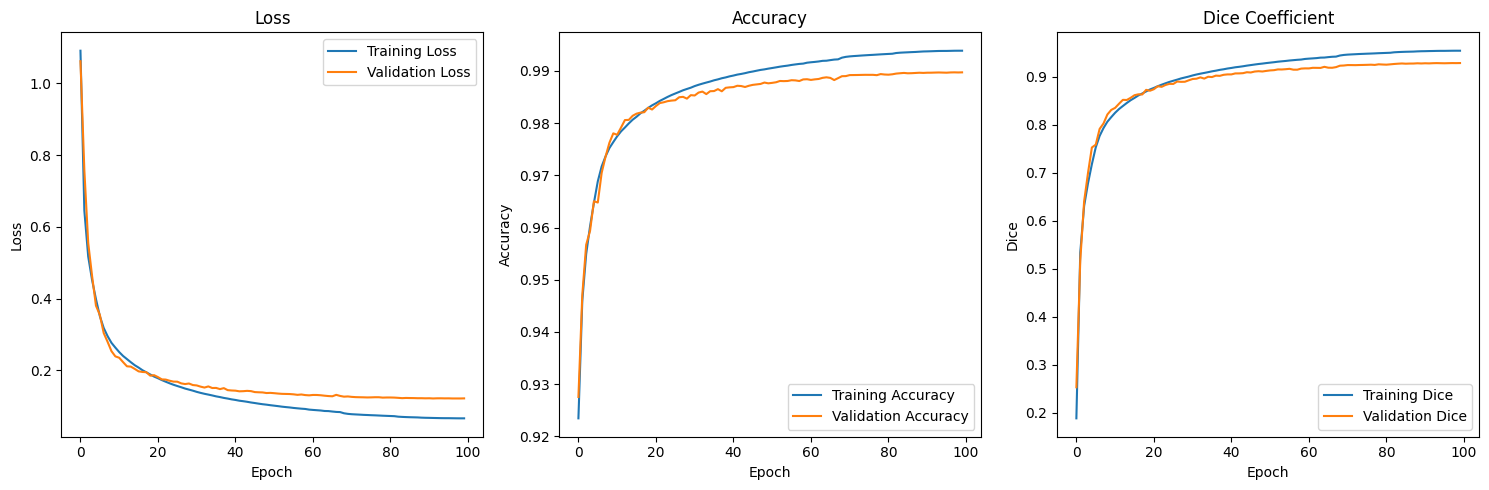

In [9]:
# Visualize training history
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Training Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

print("Plotting training history...")
plot_training_history(history)


In [10]:
# Model evaluation
print("Evaluating model...")
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Dice Coefficient: {evaluation[2]}")
print(f"Test IoU Score: {evaluation[3]}")



Evaluating model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.9910 - dice_coefficient: 0.9341 - iou_score: 0.8766 - loss: 0.1086
Test Loss: 0.11556832492351532
Test Accuracy: 0.9904437065124512
Test Dice Coefficient: 0.9305695295333862
Test IoU Score: 0.8702965378761292


In [11]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_test_bin = (y_test > 0.5).astype(np.uint8)

# Calculate metrics
dice_scores = [dice_coefficient(y_true, y_pred).numpy() for y_true, y_pred in zip(y_test_bin, y_pred_bin)]
iou_scores = [iou_score(y_true, y_pred).numpy() for y_true, y_pred in zip(y_test_bin, y_pred_bin)]
dice_mean = np.mean(dice_scores)
iou_mean = np.mean(iou_scores)

print(f"Mean Dice Score: {dice_mean}")
print(f"Mean IoU Score: {iou_mean}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step
Mean Dice Score: 0.9276444911956787
Mean IoU Score: 0.8719319105148315


In [12]:
# Confusion matrix
flat_y_test = y_test_bin.flatten()
flat_y_pred = y_pred_bin.flatten()
cm = confusion_matrix(flat_y_test, flat_y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")


Confusion Matrix:
[[24140828   110989]
 [  139522  1823061]]
Accuracy: 0.9904
Sensitivity (Recall): 0.9289
Specificity: 0.9954
Precision: 0.9426


Visualizing random predictions...


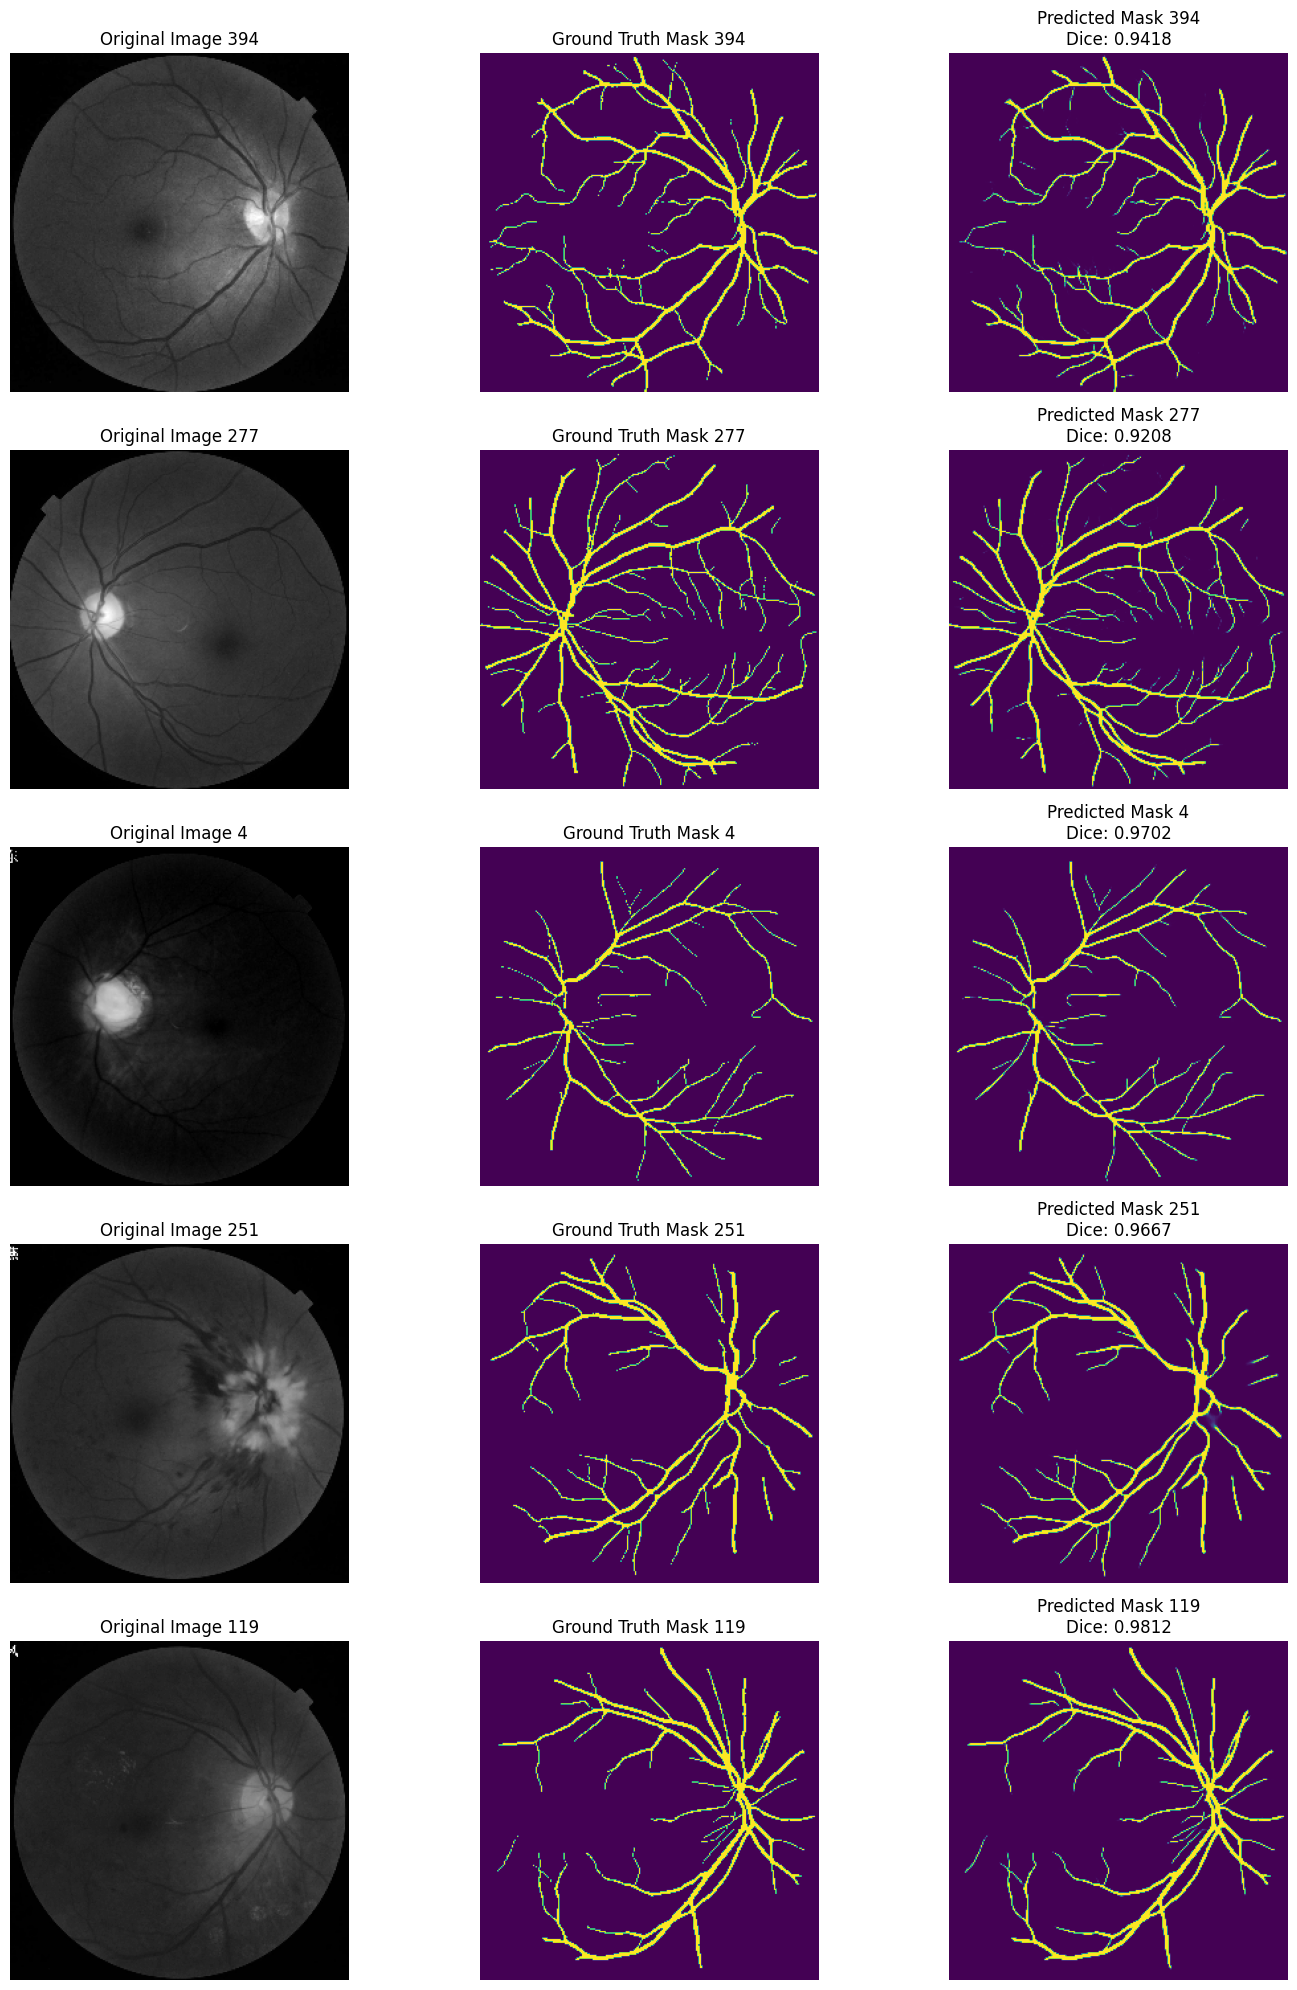

In [13]:
# Function to visualize random predictions
def visualize_random_predictions(X_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(X_test)), num_samples)
    
    plt.figure(figsize=(15, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"Original Image {idx}")
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_test[idx].squeeze(), cmap='viridis')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='viridis')
        dice_val = dice_coefficient(y_test[idx], y_pred_bin[idx]).numpy()
        plt.title(f"Predicted Mask {idx}\nDice: {dice_val:.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('random_predictions.png')
    plt.show()

# Visualize predictions on random test samples
print("Visualizing random predictions...")
visualize_random_predictions(X_test, y_test, y_pred)


Visualizing random predictions...


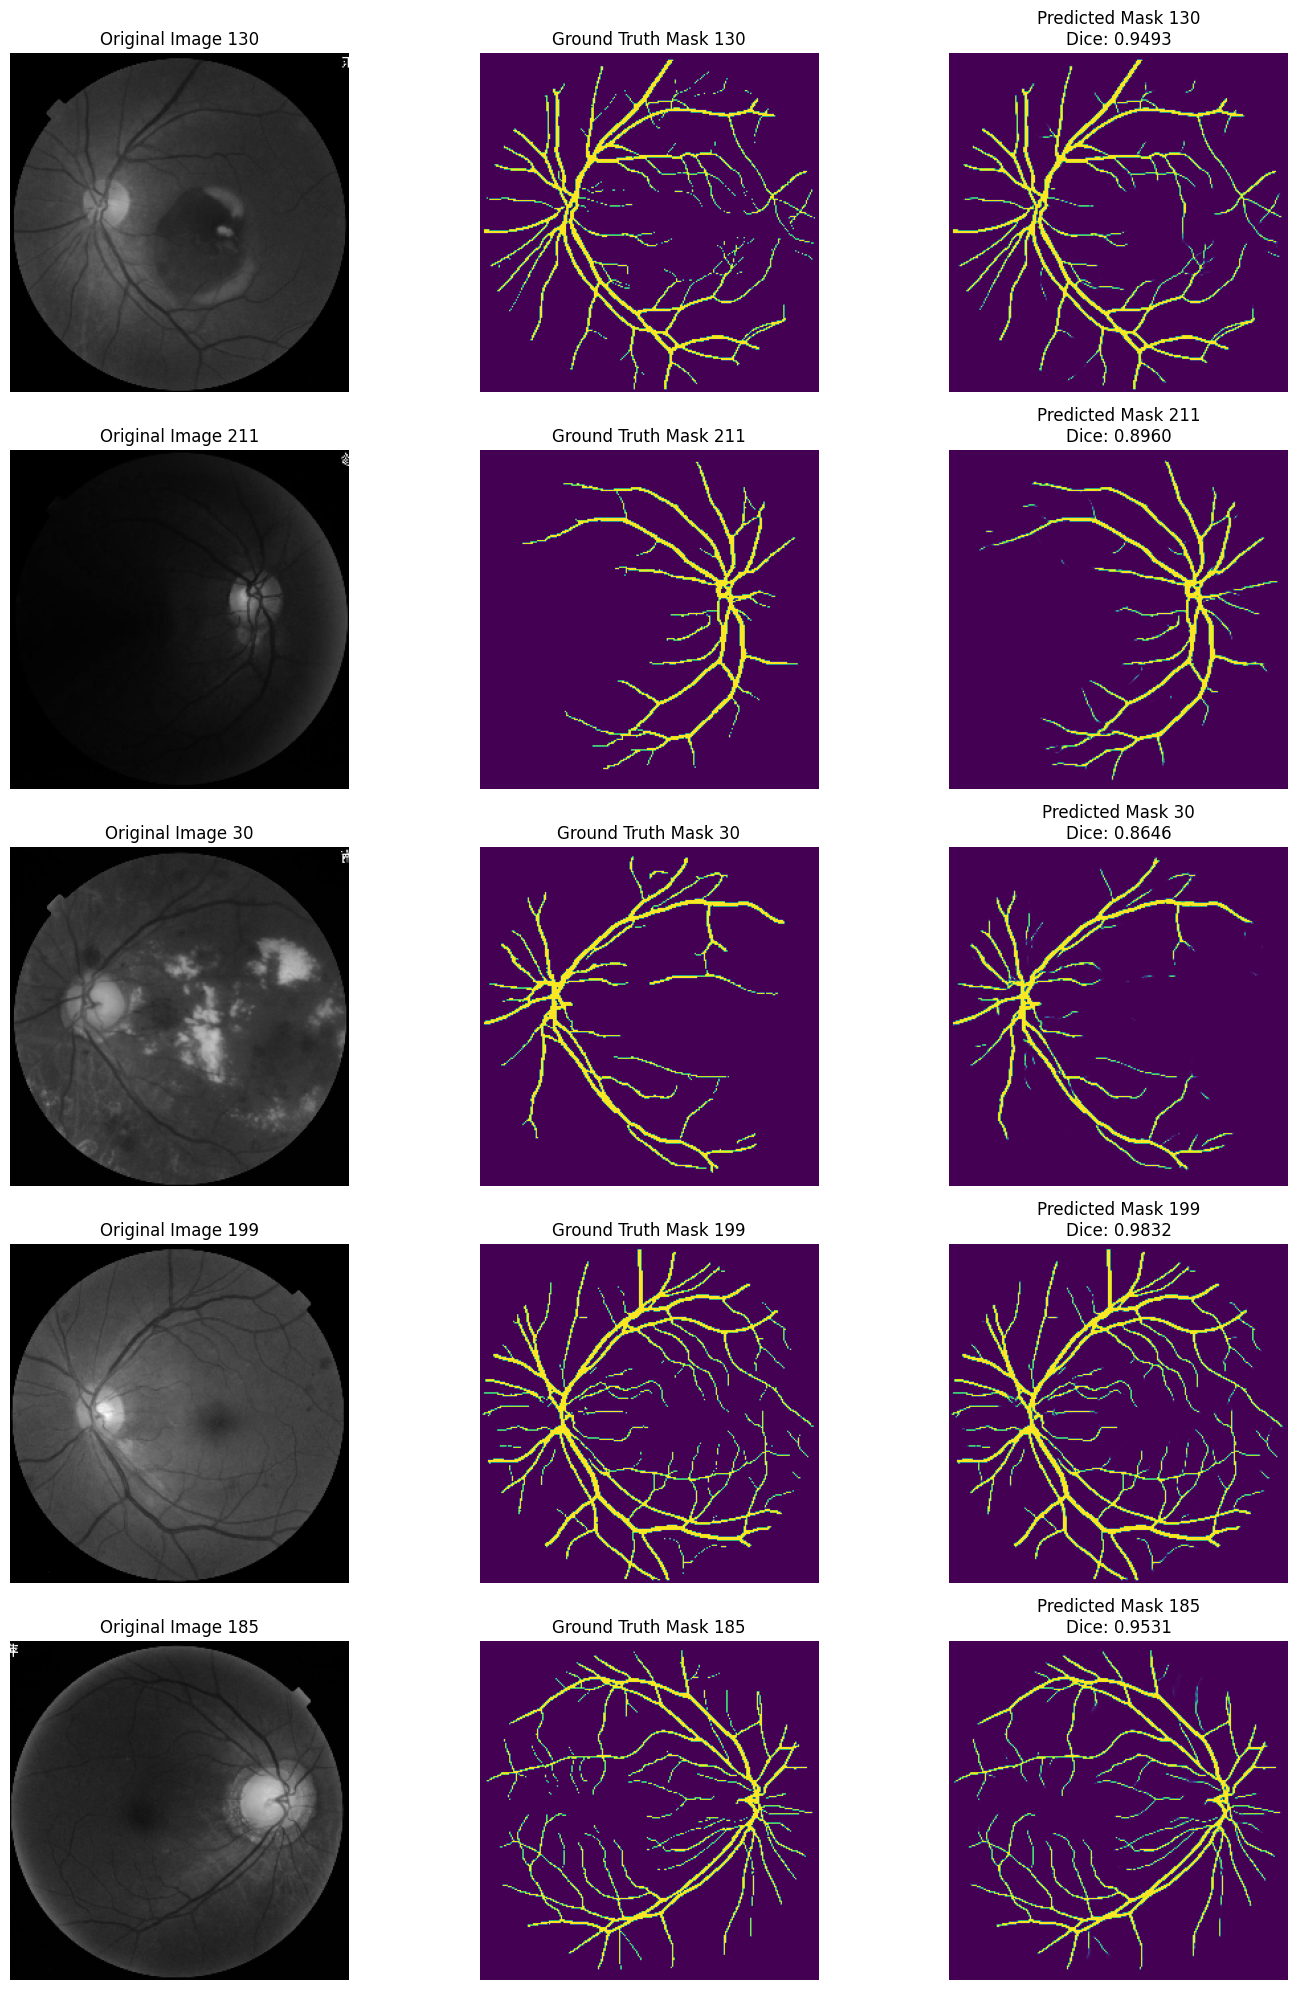

In [14]:
# Function to visualize random predictions
def visualize_random_predictions(X_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(X_test)), num_samples)
    
    plt.figure(figsize=(15, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"Original Image {idx}")
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_test[idx].squeeze(), cmap='viridis')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='viridis')
        dice_val = dice_coefficient(y_test[idx], y_pred_bin[idx]).numpy()
        plt.title(f"Predicted Mask {idx}\nDice: {dice_val:.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('random_predictions.png')
    plt.show()

# Visualize predictions on random test samples
print("Visualizing random predictions...")
visualize_random_predictions(X_test, y_test, y_pred)
